<a href="https://colab.research.google.com/github/Godvampire07/NLP_LAB/blob/main/NLP_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import re

pattern = re.compile(r'^[a-z]+$')

for w in ['cat','dog','a','zebra','dog1','1dog','DogHouse',' cats','']:
    print(repr(w), 'Accepted' if pattern.fullmatch(w) else 'Not Accepted')


'cat' Accepted
'dog' Accepted
'a' Accepted
'zebra' Accepted
'dog1' Not Accepted
'1dog' Not Accepted
'DogHouse' Not Accepted
' cats' Not Accepted
'' Not Accepted


In [1]:
import string

def is_valid_word(word):
    # DFA states
    Q_START = 0
    Q_WORD = 1
    Q_DEAD = -1

    LOWER = set(string.ascii_lowercase)  # a-z
    state = Q_START

    for ch in word:
        if state == Q_START:
            if ch in LOWER:
                state = Q_WORD
            else:
                state = Q_DEAD
        elif state == Q_WORD:
            if ch in LOWER:
                state = Q_WORD
            else:
                state = Q_DEAD
        if state == Q_DEAD:
            return "Not Accepted"

    return "Accepted" if state == Q_WORD else "Not Accepted"


# Test cases
words = ["cat", "dog", "a", "zebra", "dog1", "1dog", "DogHouse", "Dog_house", " cats"]
for w in words:
    print(f"{w!r} -> {is_valid_word(w)}")


'cat' -> Accepted
'dog' -> Accepted
'a' -> Accepted
'zebra' -> Accepted
'dog1' -> Not Accepted
'1dog' -> Not Accepted
'DogHouse' -> Not Accepted
'Dog_house' -> Not Accepted
' cats' -> Not Accepted


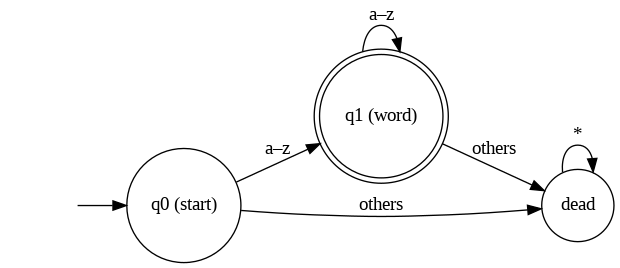

In [2]:
from graphviz import Digraph
# Define DFA details
Q_START = 'q0'
Q_WORD = 'q1'
Q_DEAD = 'q_dead'
accepting = {Q_WORD}

def draw_dfa(filename='dfa_simplified_word'):
    g = Digraph('dfa', format='png')
    g.attr(rankdir='LR')  # Left-to-right orientation

    # Invisible start node
    g.node('', shape='none')

    # States
    g.node(Q_START, shape='circle', label='q0 (start)')
    g.node(Q_WORD, shape='doublecircle', label='q1 (word)')
    g.node(Q_DEAD, shape='circle', label='dead')

    # Start arrow
    g.edge('', Q_START)

    # Transitions
    g.edge(Q_START, Q_WORD, label='a–z')
    g.edge(Q_START, Q_DEAD, label='others')
    g.edge(Q_WORD, Q_WORD, label='a–z')
    g.edge(Q_WORD, Q_DEAD, label='others')
    g.edge(Q_DEAD, Q_DEAD, label='*')

    # Render and display
    output_path = g.render(filename, cleanup=True)
    from IPython.display import Image
    return Image(filename=output_path)

# Call the function to display DFA in Colab
draw_dfa()


In [8]:
with open('/brown_nouns.txt', 'r') as f:
    print(f.read())


investigation
primary
election
evidence
irregularities
place
jury
presentments
charge
election
praise
thanks
manner
election
term
jury
reports
irregularities
primary
handful
reports
jury
interest
election
number
voters
size
city
jury
registration
election
laws
legislators
laws
end
jury
number
topics
departments
practices
interest
governments
jury
offices
efficiency
cost
administration
jury
personnel
result
city
personnel
policies
city
steps
problem
Implementation
automobile
title
law
jury
funds
date
implementation
law
jury
swipe
handling
funds
child
welfare
services
homes
items
assistance
program
jury
funds
welfare
departments
counties
state
exception
money
jurors
distribution
funds
program
counties
future
portion
funds
jurors
Failure
burden
taxpayers
jury
court
fire
practices
appointment
appraisers
guardians
administrators
awarding
fees
compensation
jury
court
procedures
recommendations
juries
interim
citizens
committee
actions
fact
effect
wards
costs
servants
criticisms
jury
airport


In [9]:
"""
Usage:
  python fst_morph.py path/to/brown_nouns.txt

"""

import sys
import os

def is_vowel(ch):
    return ch in "aeiou"

def read_file(path):
    s = set()
    with open(path, encoding='utf8') as f:
        for line in f:
            w = line.strip()
            if not w:
                continue
            s.add(w.lower())
    return s

def analyze_token(token, nouns_set):
    """
    Implements the suffix-class based FST described.
    Returns analysis string (e.g., 'fox+N+PL' or 'fox+N+SG' or 'Invalid Word').
    """
    orig = token
    w = token.lower()

    # quick present check: if exact word is in noun set -> could be SG (but still may be PL too)
    # We'll attempt plural analyses first (try to see if token is plural) then fallback to SG.
    # order: ies -> es -> s -> SG -> Invalid


    # Helper: validation checks whether candidate root is acceptable given suffix rules
    def valid_regular_s(candidate_root):

        # if root endswith s, z, x, ch, sh -> regular 's' plural is not allowed (should be 'es').
        if candidate_root.endswith(('s','z','x')):
            return False
        if candidate_root.endswith('ch') or candidate_root.endswith('sh'):
            return False


        # if root endswith consonant+y then plural should be 'ies' not 'ys'
        if candidate_root.endswith('y'):
            if len(candidate_root) >= 2:
                if not is_vowel(candidate_root[-2]):  # consonant before y -> uses 'ies'
                    return False
        return True


    # 1) 'ies' => root = w[:-3] + 'y' (only valid if candidate root exists)
    if w.endswith('ies') and len(w) > 3:
        cand = w[:-3] + 'y'
        if cand in nouns_set:
            # additional sanity: only accept if original singular wouldn't be valid with 's' (to avoid wrong matches)
            # e.g., 'cities' -> cand 'city' ok
            return f"{cand}+N+PL"
        # else continue to other checks (maybe it's 'xies' etc. unlikely)

    # 2) 'es' endings
    if w.endswith('es') and len(w) > 2:
        # candidate1: remove 'es' -> maybe root that ends with s,z,x,ch,sh
        cand1 = w[:-2]
        # sometimes words like 'houses' -> root is 'house' (w[:-1]) so we must check both
        cand2 = w[:-1]  # remove only 's' -> maybe root had final 'e' like 'house' -> 'houses'

        # Accept cand1 if it exists and the root ends with a special ending that typically requires 'es'
        if cand1 in nouns_set and (cand1.endswith(('s','z','x')) or cand1.endswith('ch') or cand1.endswith('sh')):
            return f"{cand1}+N+PL"

        # Accept cand2 if cand2 exists and cand2 does not *require* the 'es' pattern to be 'es' exclusive.
        # Example: 'houses' -> cand1='hous' (no), cand2='house' (yes) => regular plural by adding 's' to house yields 'houses'
        if cand2 in nouns_set and valid_regular_s(cand2):
            return f"{cand2}+N+PL"

        # There are other irregulars; if cand1 in nouns_set we can still accept (defensive)
        if cand1 in nouns_set:
            return f"{cand1}+N+PL"

    # 3) plain 's' endings (not 'es' or 'ies')
    if w.endswith('s') and not w.endswith('es') and not w.endswith('ies') and len(w) > 1:
        cand = w[:-1]
        if cand in nouns_set:
            # but if cand finishes with letter that requires 'es' or 'ies', then cand+"s" is invalid (e.g., foxs)
            if valid_regular_s(cand):
                return f"{cand}+N+PL"
            else:
                return "Invalid Word"

    # 4) fallback: if token exactly in noun set => singular
    if w in nouns_set:
        return f"{w}+N+SG"

    # 5) invalid
    return "Invalid Word"

def process_file(path):
    nouns_set = read_file(path)
    out_lines = []
    with open(path, encoding='utf8') as f:
        for raw in f:
            tok = raw.strip()
            if not tok:
                continue
            analysis = analyze_token(tok, nouns_set)
            out_lines.append(f"{tok} = {analysis}")
    return out_lines

# Path to your file in Colab
file_path = "/brown_nouns.txt"

if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    results = process_file(file_path)
    for line in results:
        print(line)

Streaming output truncated to the last 5000 lines.
street = street+N+SG
clothes = cloth+N+PL
release = release+N+SG
head = head+N+SG
moments = moment+N+PL
clothes = cloth+N+PL
bench = bench+N+SG
shoe = shoe+N+SG
plenty = plenty+N+SG
guys = guy+N+PL
leagues = league+N+PL
guys = guy+N+PL
club = club+N+SG
hell = hell+N+SG
right = right+N+SG
thing = thing+N+SG
thing = thing+N+SG
job = job+N+SG
job = job+N+SG
outfielders = outfielder+N+PL
way = way+N+SG
interest = interest+N+SG
product = product+N+SG
insularity = insularity+N+SG
reading = reading+N+SG
religion = religion+N+SG
subject = subject+N+SG
religion = religion+N+SG
tomes = tomes+N+SG
papers = paper+N+PL
birthday = birthday+N+SG
store = store+N+SG
mother = mother+N+SG
image = image+N+SG
god = god+N+SG
day = day+N+SG
mother = mother+N+SG
present = present+N+SG
gift = gift+N+SG
room = room+N+SG
dinner = dinner+N+SG
night = night+N+SG
god = god+N+SG
father = father+N+SG
laughter = laughter+N+SG
mother = mother+N+SG
father = father+N+SG


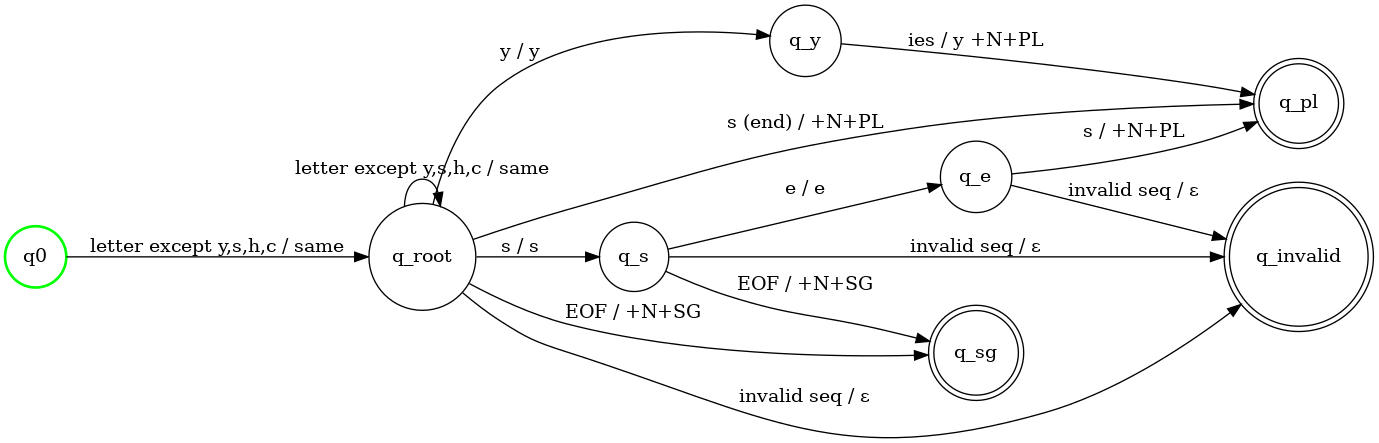

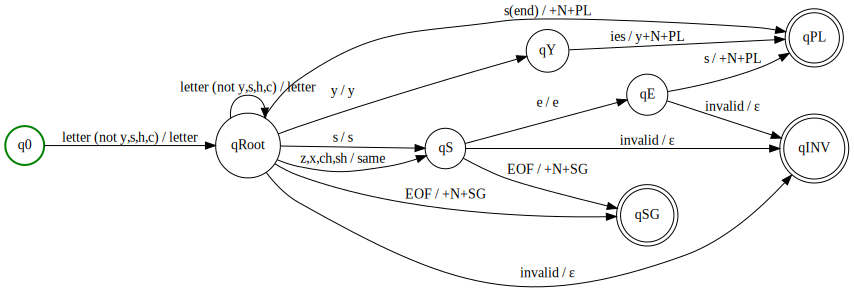

In [11]:
import graphviz

# Initialize directed graph
fst = graphviz.Digraph('NounPluralFST', format='png')
fst.attr(rankdir='LR')

# States: q0 = start, qSG = singular final, qPL = plural final, qINV = invalid final
states = {
    "q0": {"start": True, "final": False},
    "qRoot": {"start": False, "final": False},
    "qY": {"start": False, "final": False},
    "qS": {"start": False, "final": False},
    "qE": {"start": False, "final": False},
    "qSG": {"start": False, "final": True},
    "qPL": {"start": False, "final": True},
    "qINV": {"start": False, "final": True}
}

# Add states
for name, props in states.items():
    if props["start"]:
        fst.node(name, shape="circle", style="bold", color="green")
    elif props["final"]:
        fst.node(name, shape="doublecircle")
    else:
        fst.node(name, shape="circle")

# Transitions
fst.edge("q0", "qRoot", label="letter (not y,s,h,c) / letter")
fst.edge("qRoot", "qRoot", label="letter (not y,s,h,c) / letter")

# Y-ending rule
fst.edge("qRoot", "qY", label="y / y")
fst.edge("qY", "qPL", label="ies / y+N+PL")

# E-insertion rule
fst.edge("qRoot", "qS", label="s / s")
fst.edge("qRoot", "qS", label="z,x,ch,sh / same")
fst.edge("qS", "qE", label="e / e")
fst.edge("qE", "qPL", label="s / +N+PL")

# Simple S-addition
fst.edge("qRoot", "qPL", label="s(end) / +N+PL")

# Singular word ending
fst.edge("qRoot", "qSG", label="EOF / +N+SG")
fst.edge("qS", "qSG", label="EOF / +N+SG")

# Invalid sequences
fst.edge("qRoot", "qINV", label="invalid / ε")
fst.edge("qS", "qINV", label="invalid / ε")
fst.edge("qE", "qINV", label="invalid / ε")

# Display directly in output cell
fst
